# AFV code demonstration

We demonstrate the code used in the paper *Efficient simulation of affine forward variance models*.

In [1]:
library(repr)

In [2]:
source("BlackFormula.R")
source("AFVsimulation.R")
source("GammaKernel.R")
source("roughHestonAdams.R")
source("roughHestonPade.R")
source("Lewis.R")

In [3]:
bl <- "royalblue"
rd <- "red2"
pk <- "hotpink1"
gr <- "green4"

### Parameters

We choose parameters similar to those found from a fit to SPX options as of May 19, 2017, the same data that was used in Roughening Heston.

In [4]:
params0 <- list(al=0.55,lam=0,eta=0.8,rho=-0.65, H=0.05,lam=0)
xi0 <- function(s){0.025+0*s} # The forward variance curve

### Simulation using the RSQE and HQE schemes

The option "all" returns a list with many variables of interest.

In [5]:
system.time(rsqe.sim <- RSQE.sim(params0, xi0)(paths=100000, steps=100, expiries=1,output="all"))

   user  system elapsed 
  6.382   1.968   8.351 

In [6]:
system.time(hqe.sim.100 <- HQE.sim(params0, xi0)(paths=100000, steps=100, expiries=1,output="all"))

   user  system elapsed 
  9.219   2.944  12.180 

In [7]:
system.time(hqe.sim.200 <- HQE.sim(params0, xi0)(paths=100000, steps=200, expiries=1,output="all"))

   user  system elapsed 
 24.738   8.672  33.467 

In [8]:
names(hqe.sim.100)

[1] "v" "x" "y" "w"

- v is terminal variance $v_T$
- x is terminal log-spot $X_T$
- y is terminal value of $Y_T = \int_0^T\,\sqrt{v_s}\,dW_s$.
- w is terminal value of quadratic variation $w_T = \int_0^T\,{v_s}\,ds$.

#### Parallelization

The code can be run in parallel with selected variables as output.

For example, here with $v_T$ as output.

In [9]:
library(foreach)
library(doParallel)

Loading required package: iterators

Loading required package: parallel



In [10]:
paths <- 1000000 # Note 1 million paths here!
steps <- 100

In [11]:
t0<-proc.time()

# Number of iterations
iters<- max(1,floor(paths/1000))

# Setup parallel backend to use all processors
(cl.num <- detectCores()) # Display number of processors on your machine
cl<-makeCluster(cl.num)
registerDoParallel(cl)

# Loop
ls <- foreach(icount(iters)) %dopar% {
        HQE.sim(params0, xi0)(paths=1000, steps=steps, expiries=1,output="v")
        }

stopCluster(cl)
    hqe.sim.v <- do.call(cbind, ls) #Bind all of the submatrices into one big matrix

print(proc.time()- t0)

[1] 16

   user  system elapsed 
  0.645   0.277  21.369 


### Figure 7.6: Histograms of $v_T$

In [12]:
options(repr.plot.width=14,repr.plot.height=7,repr.plot.res=150)

In [13]:
vv <- hqe.sim.v

In [14]:
vvg <- vv[vv > 1e-9] # Restrict sample to values greater than tiny

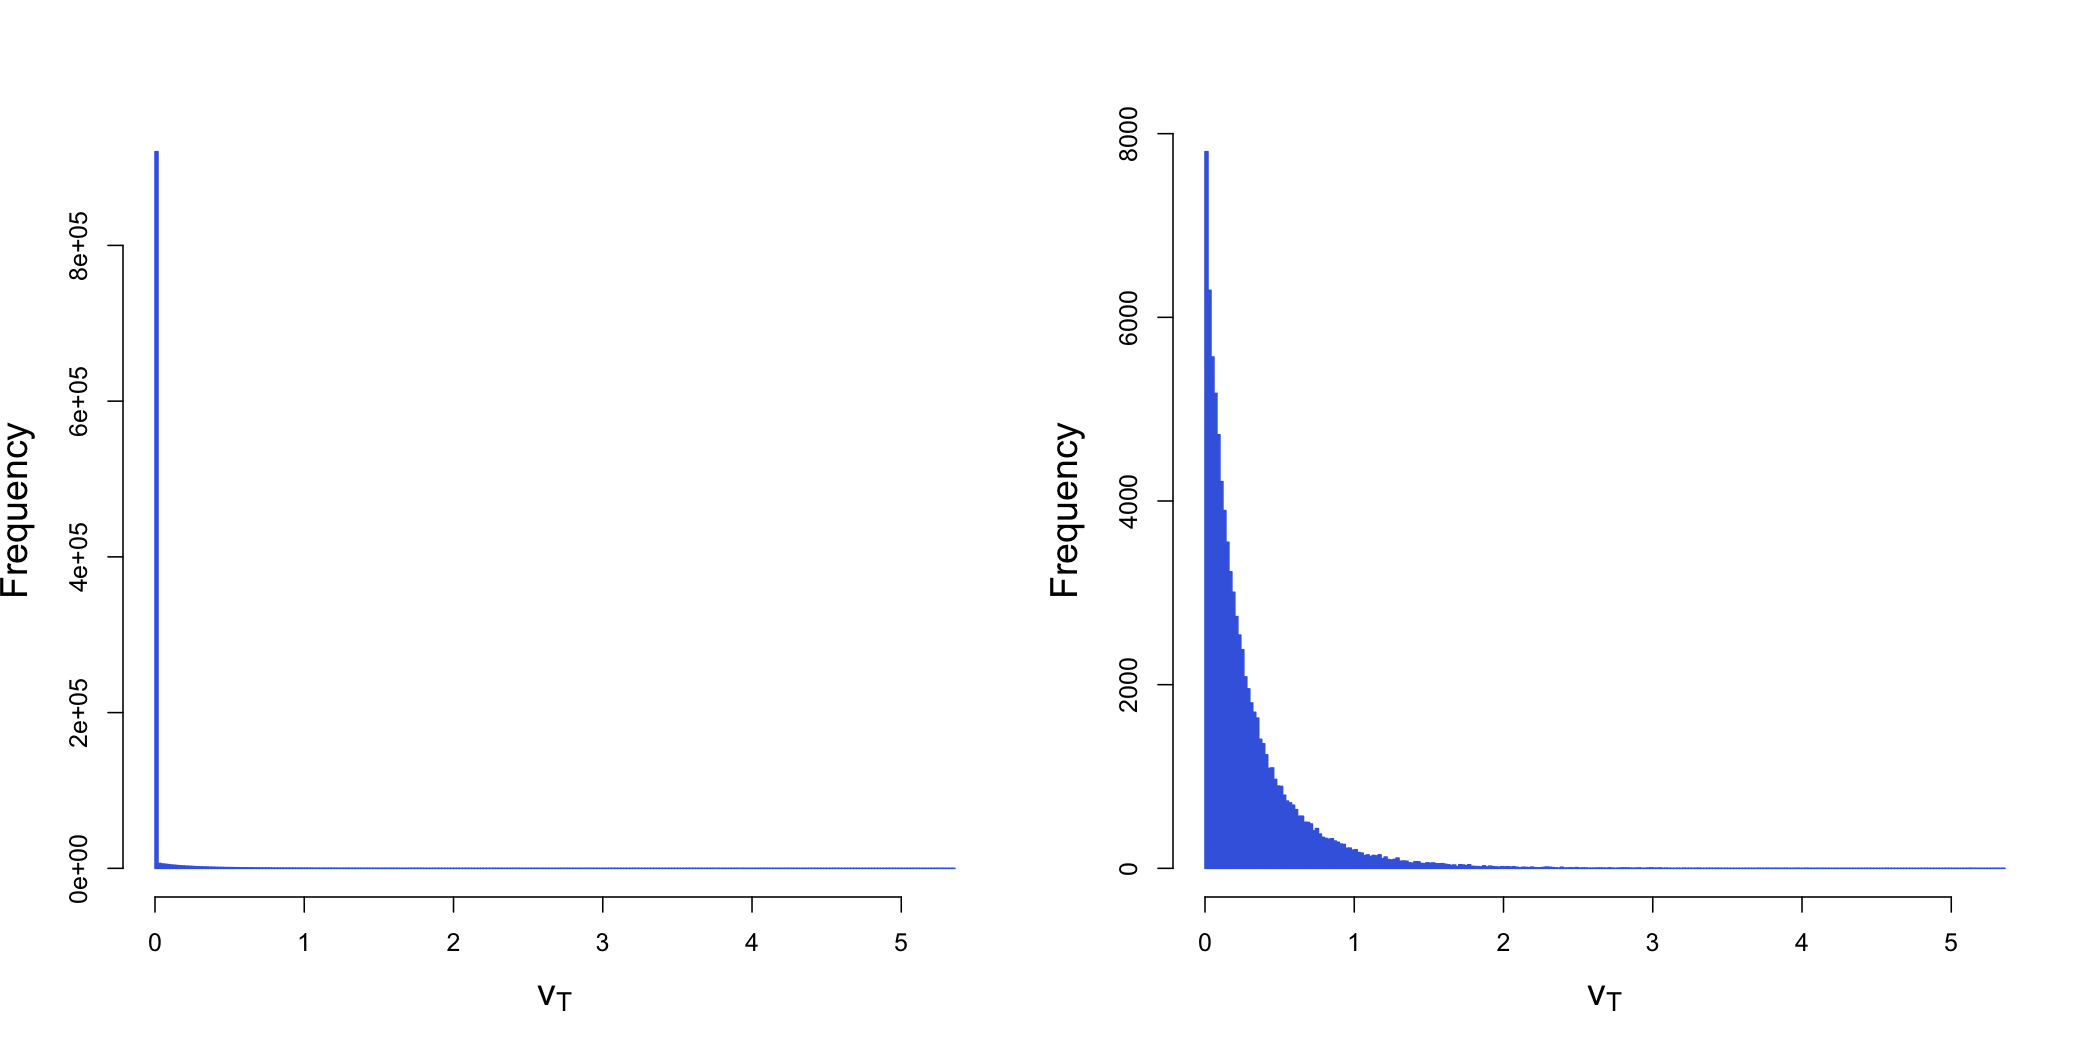

In [15]:
par(mfrow=c(1,2))
hist(vv,breaks=200,xlab=expression(v[T]),main="",col=bl, border=bl, cex.lab=1.5)
par(new=F)
hist(vvg,breaks=200,xlab=expression(v[T]),main="",col=bl,border=bl, cex.lab=1.5)
par(mfrow=c(1,1))

### Histograms of terminal stock prices

In [16]:
spots.100 <- exp(hqe.sim.100$x)
spots.200 <- exp(hqe.sim.200$x)

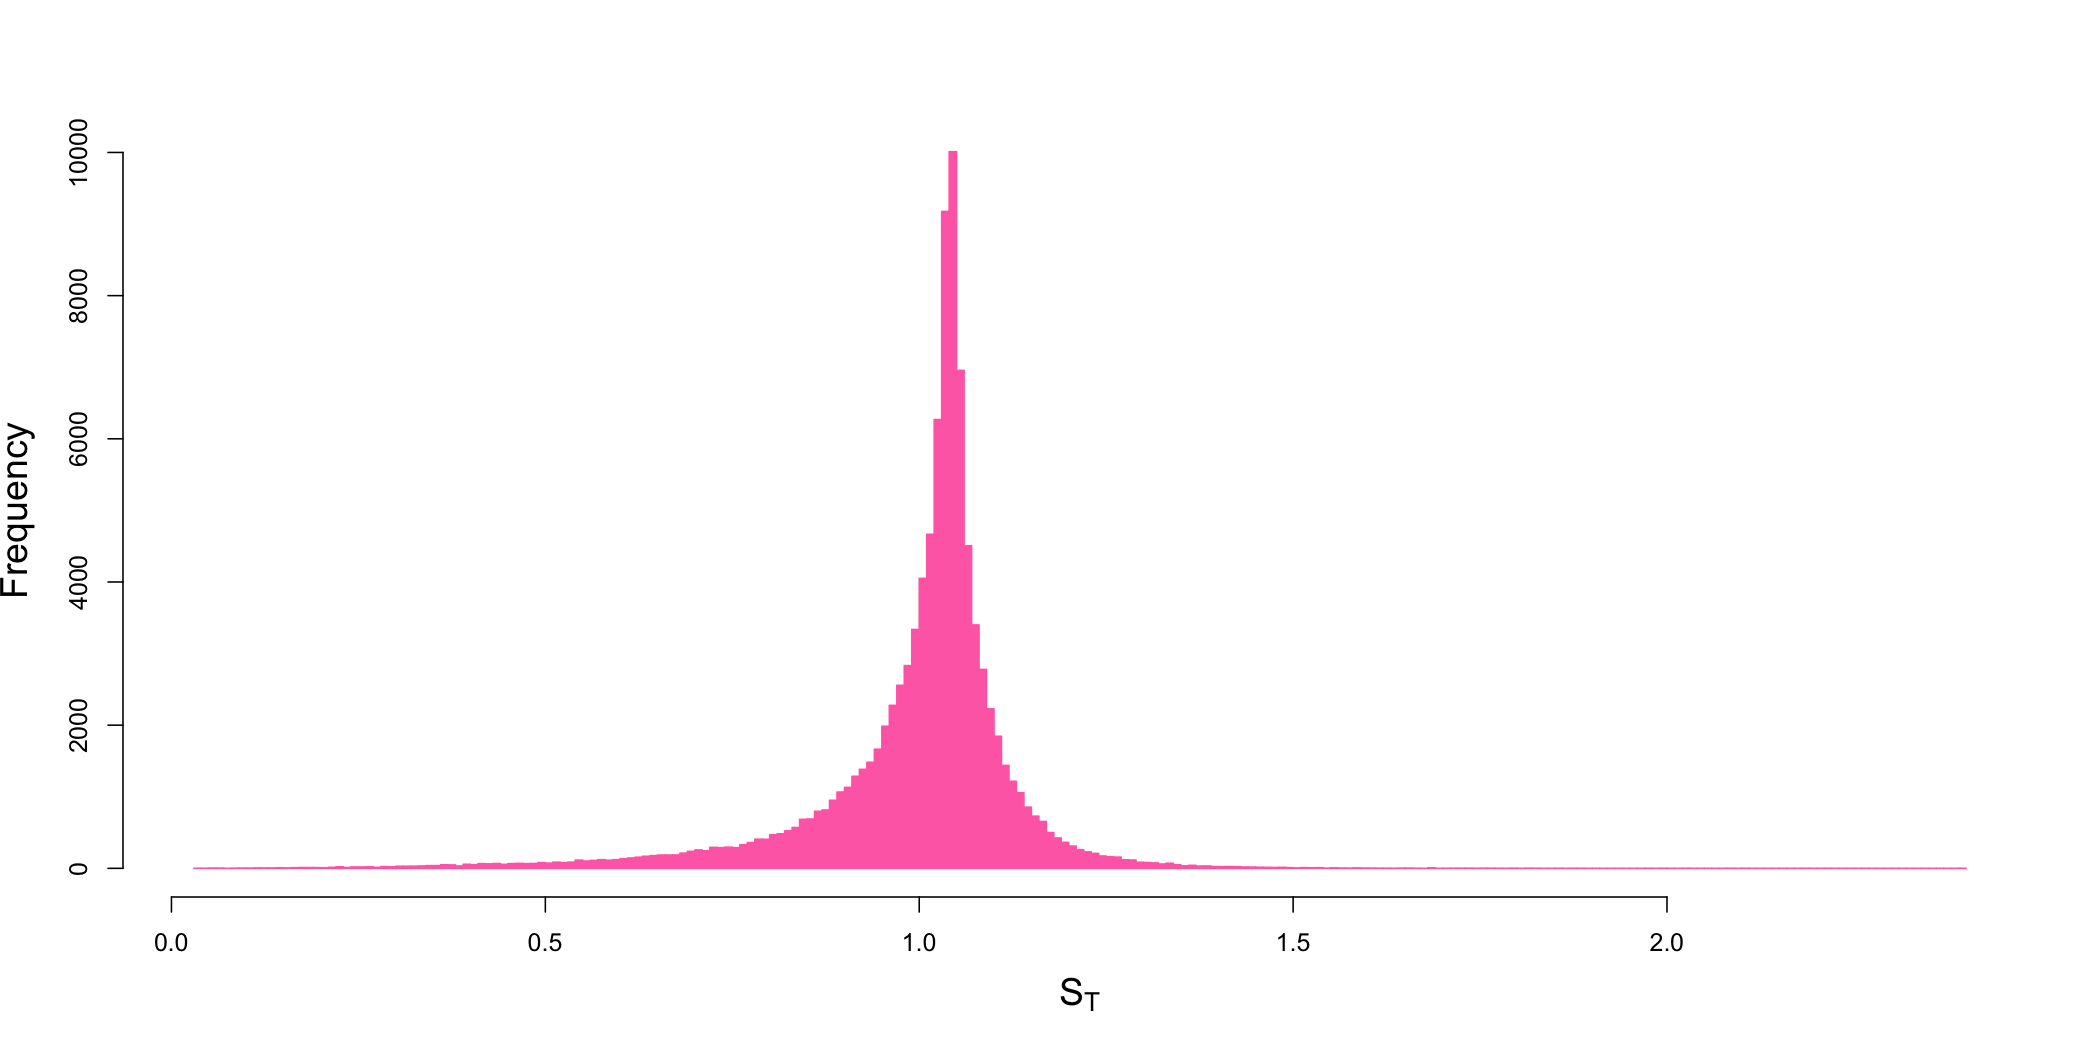

In [17]:
hist(spots.100,breaks=200,xlab=expression(S[T]),main="",col=pk, border=pk, cex.lab=1.5)

Note the fat negative tail in the return distribution.

### Draw the 1 year smile with the above parameters

In [18]:
smile.100 <- function(k){ivS(spots.100, T=1, mean(spots.100)*exp(k))}
smile.200 <- function(k){ivS(spots.200, T=1, mean(spots.200)*exp(k))}

We select a vector of log-strikes.

In [19]:
kk <- seq(-.4,.4,.01)

In [20]:
smile.HQE.100 <- smile.100(kk)
smile.HQE.200 <- smile.200(kk)

In [21]:
options(repr.plot.width=10,repr.plot.height=7,repr.plot.res=150)

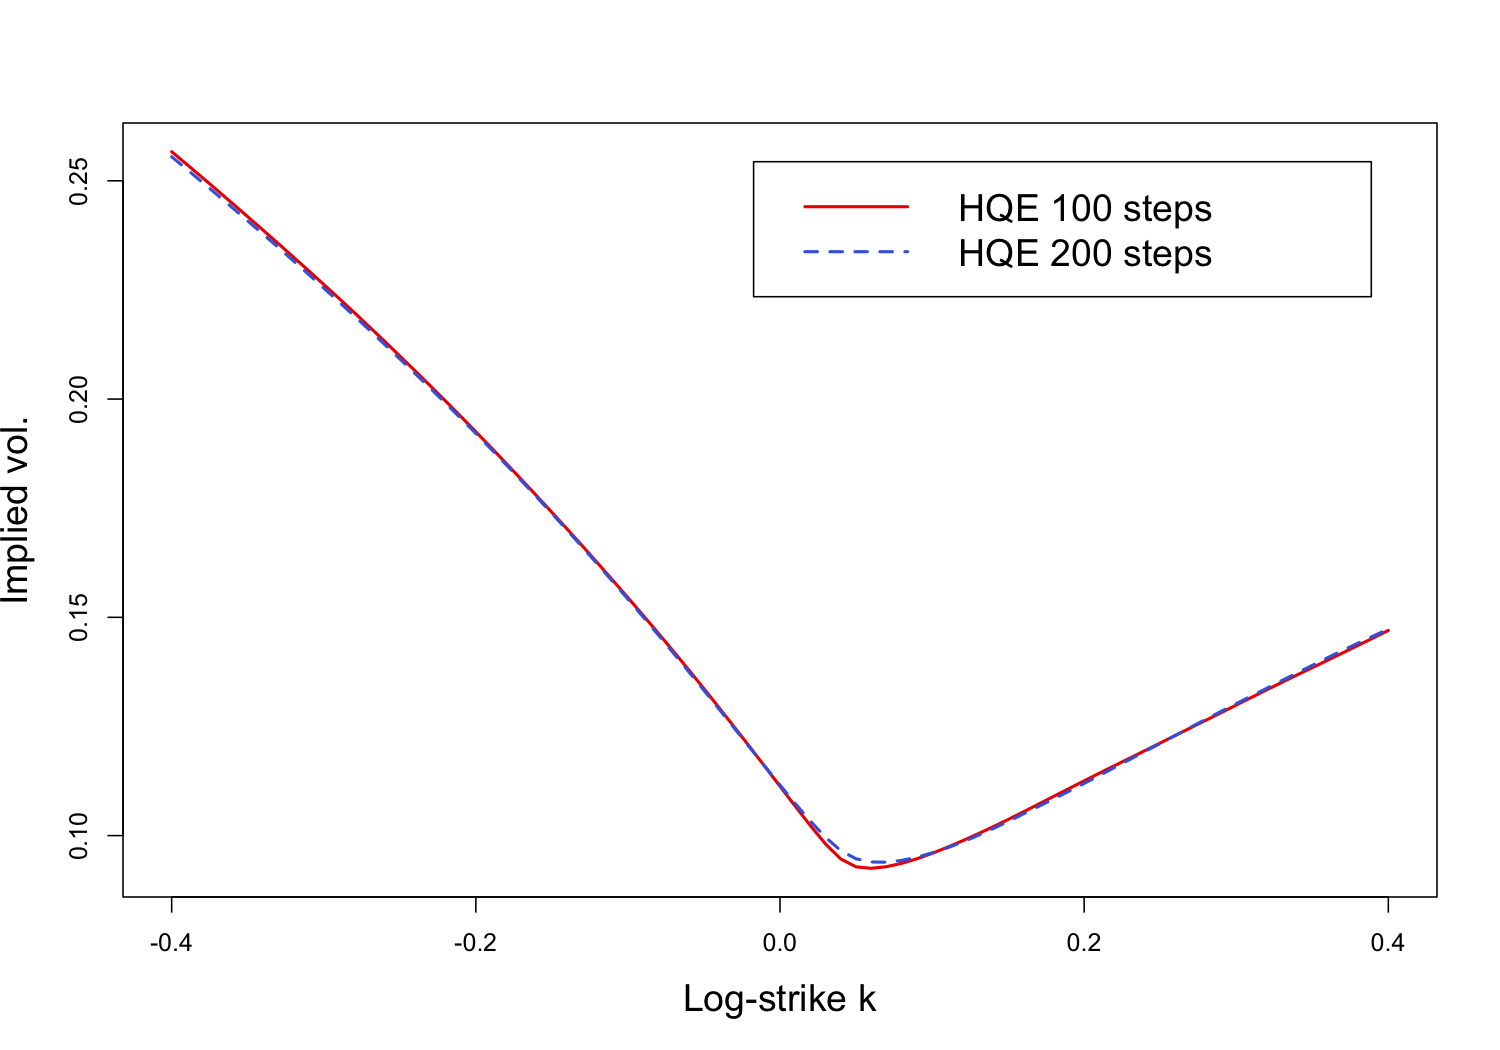

In [22]:
plot(kk,smile.HQE.100,col=rd,lwd=2,type="l",
     xlab="Log-strike k", ylab = "Implied vol.",cex.lab=1.5)
lines(kk,smile.HQE.200,col=bl,lwd=2,lty=2)
legend("topright",c("HQE 100 steps","HQE 200 steps"), cex=1.5, inset=.05, 
       lty=c(1,2),col=c(rd,bl), lwd=2)

### Richardson extrapolated smile

In [23]:
smile.HQE.Richardson <- 2*smile.200(kk)-smile.100(kk)

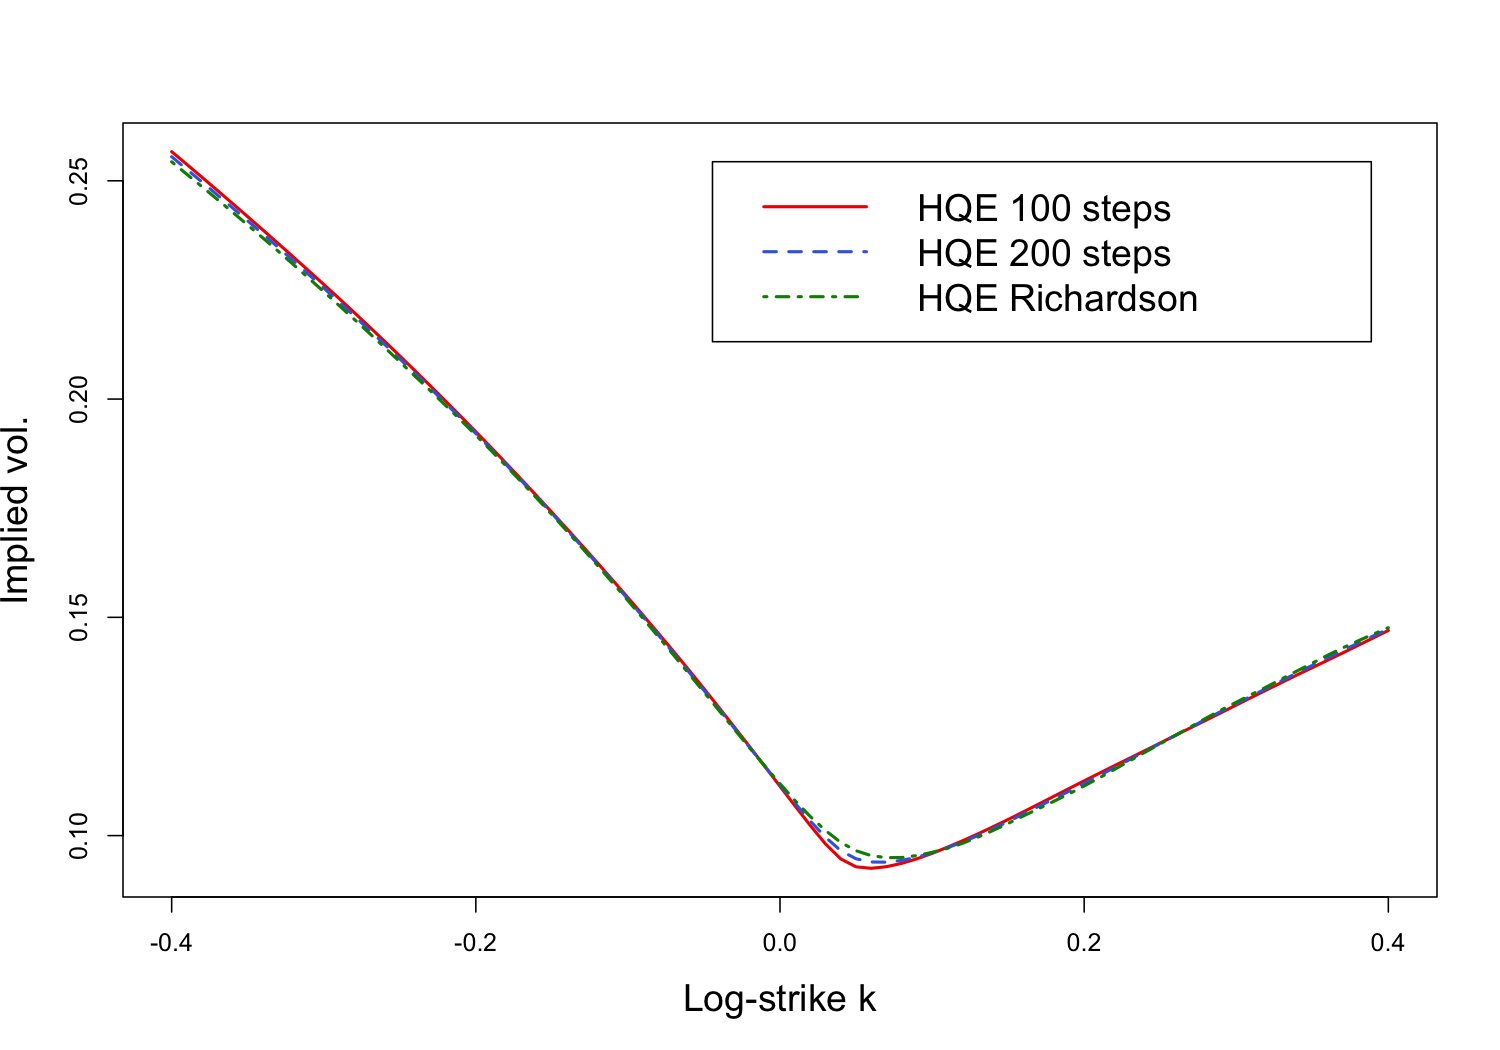

In [24]:
plot(kk,smile.HQE.100,col=rd,lwd=2,type="l",
     xlab="Log-strike k", ylab = "Implied vol.",cex.lab=1.5)
lines(kk,smile.HQE.200,col=bl,lwd=2,lty=2)
lines(kk,smile.HQE.Richardson,col=gr,lwd=2,lty=4)
legend("topright",c("HQE 100 steps","HQE 200 steps",
    "HQE Richardson"), cex=1.5, inset=.05, 
       lty=c(1,2,4),col=c(rd,bl,gr), lwd=2)

### Parameter conversion

The QE simulation and the Adams/Padé approximations use different formulations of the rough Heston model.

In the QE case,

$$
d\xi_t(u) = \eta\,\sqrt{2 H}\,(u-t)^{\alpha-1}.
$$

In the Adams/Padé case,

$$
d\xi_t(u) = \frac{\nu}{\Gamma(\alpha)}\,(u-t)^{\alpha-1}.
$$

Thus

$$
\nu = \sqrt{2 H}\, \Gamma(\alpha)\,\eta.
$$

In [25]:
(params0$nu <- params0$eta*sqrt(2*params0$al-1)*gamma(params0$al))

[1] 0.4088507

### Comparison with Adams smile

- The Adams scheme code is orignally due to Fabio Baschetti, Giacomo Bormetti, Pietro Rossi, and Silvia Romagnoli, University of Bologna (2020).



- The code for computing the cutoff in the Lewis formula is based on code originally by Omar El Euch, École Polytechnique Paris (2017).


Note that the Adams smile takes time to compute (two minutes on my machine).

In [26]:
system.time(vol.Adams.kk.1y.200 <-  impliedVolRoughHeston(params0, xi0, nSteps=200)(kk,1))

   user  system elapsed 
103.708   6.239 110.138 

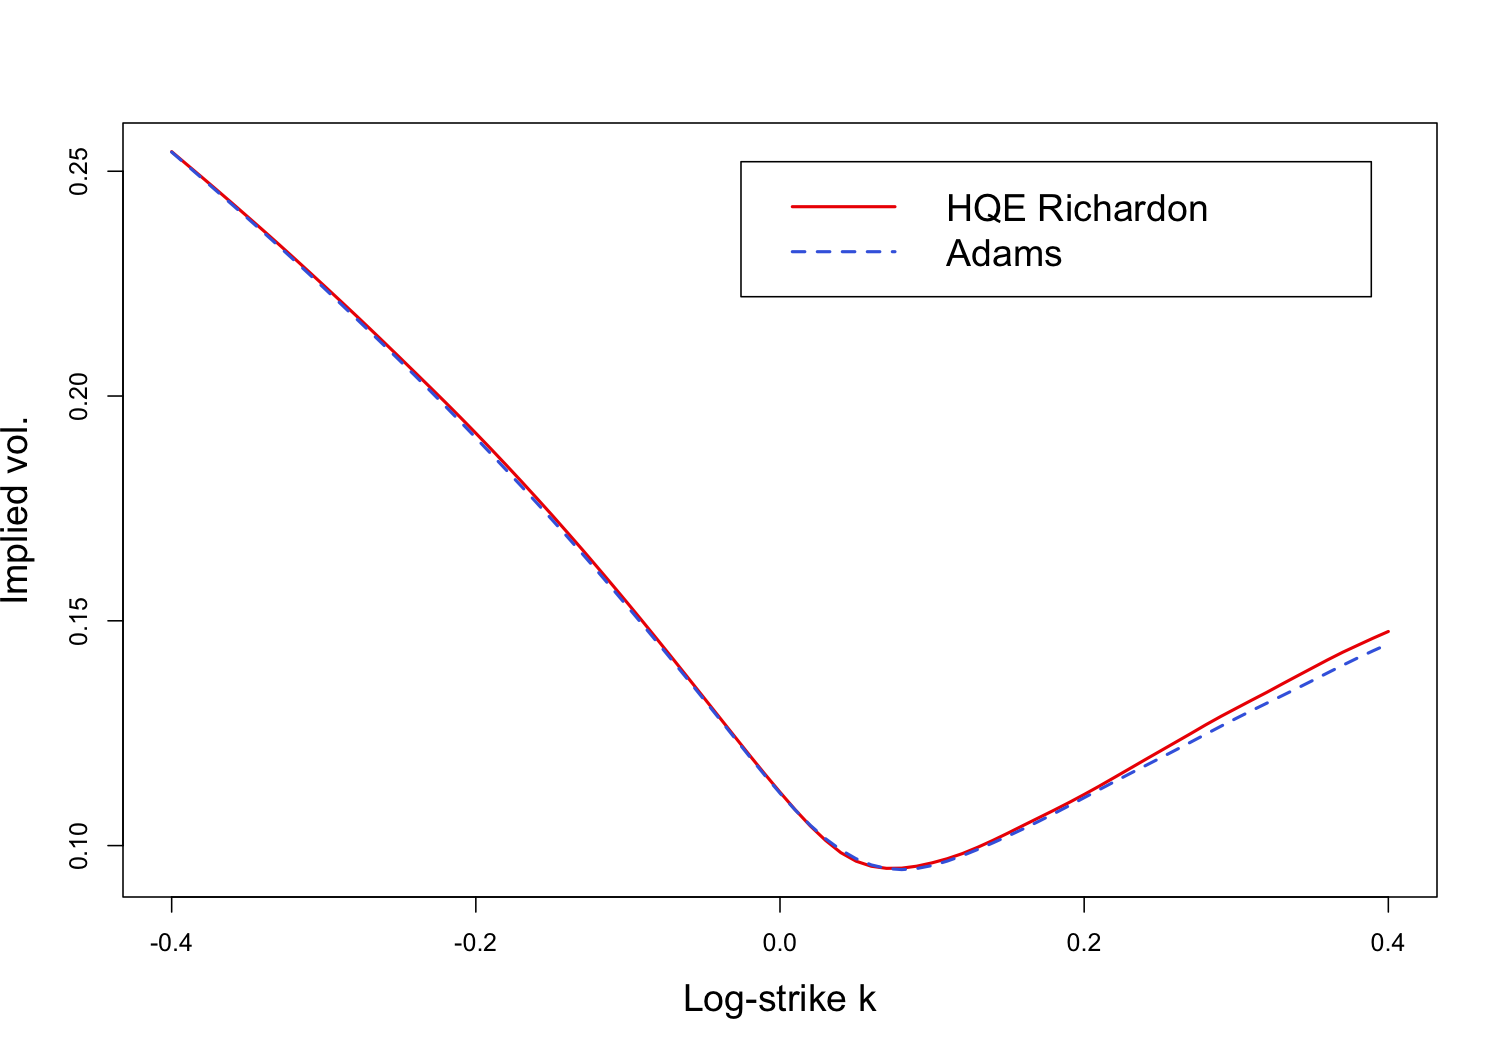

In [27]:
plot(kk,smile.HQE.Richardson,col=rd,lwd=2,type="l",
     xlab="Log-strike k", ylab = "Implied vol.",cex.lab=1.5)
lines(kk,vol.Adams.kk.1y.200,col=bl,lwd=2,lty=2)
legend("topright",c("HQE Richardon","Adams"), cex=1.5, inset=.05, 
       lty=c(1,2),col=c(rd,bl), lwd=2)

### Padé approximation

In [28]:
phi.Pade <- phiRoughHestonDhApprox(params0, xi0, dh.approx= d.h.Pade33, n=500)

In [29]:
system.time(vol.Pade.kk.1y <-  impvol.phi(phi.Pade)(kk,1))

   user  system elapsed 
  2.968   0.194   3.171 

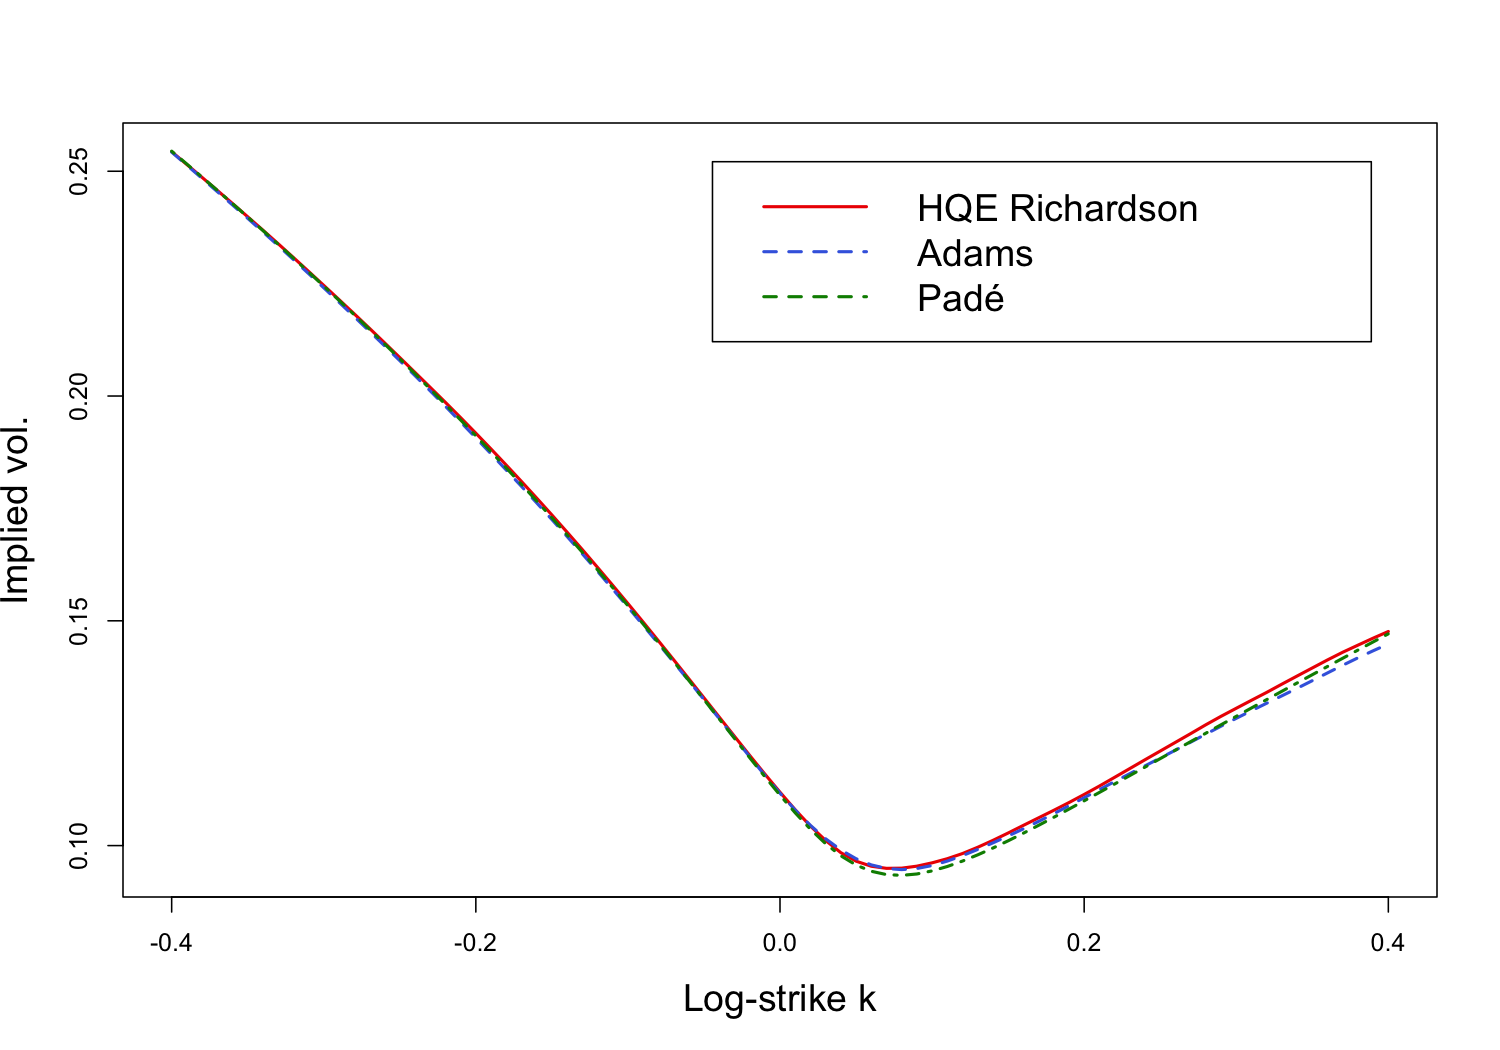

In [30]:
plot(kk,smile.HQE.Richardson,col=rd,lwd=2,type="l",
     xlab="Log-strike k", ylab = "Implied vol.",cex.lab=1.5)
lines(kk,vol.Adams.kk.1y.200,col=bl,lwd=2,lty=2)
lines(kk,vol.Pade.kk.1y,col=gr,lwd=2,lty=4)
legend("topright",c("HQE Richardson","Adams","Padé"), cex=1.5, inset=.05, 
       lty=c(1,2,2),col=c(rd,bl,gr), lwd=2)

To get reliable agreement between these smiles, a greater number of paths (such as 1 million) is needed.  Alternatively (and better), variance reduction can be implemented.